# Calculating Climatology and Departures from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 04/01/24 (v0.6.1)

Related APIs:

- [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)
- [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)


## Overview

Suppose we have two netCDF4 files for air temperature data (`tas`).

- File 1: Monthly frequency from 1850-01-16 to 2014-12-16
  - We want to calculate the annual and seasonal cycle climatologies and departures using this file.
- File 2: Hourly frequency from 2010-01-01 to 2015-01-01 (subset).
  - We want to calculate the daily cycle climatologies and departures using this file.

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/metagrid/search).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook_0.7.0 -c conda-forge xcdat=0.7.0 xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter
```

Then install the kernel from the `xcdat_notebook_0.7.0` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook_0.7.0`):

```bash
python -m ipykernel install --user --name xcdat_notebook_0.7.0 --display-name xcdat_notebook_0.7.0
```

Then to select the kernel `xcdat_notebook_0.7.0` in Jupyter to use the this kernel.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xcdat


## 1. Open Sample Datasets

We are using xarray's OPeNDAP support to read a netCDF4 dataset files directly from their source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).


### File 1: Monthly Frequency


In [2]:
filepath1 = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds_monthly = xcdat.open_dataset(filepath1)

# Unit adjust (-273.15, K to C)
ds_monthly["tas"] = ds_monthly.tas - 273.15
ds_monthly

<xarray.Dataset> Size: 221MB
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 220MB -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

### File 2: Hourly Frequency

The size of this file is approximately 1.17 GB, so we will be chunking our
request using Dask to avoid hitting the OPeNDAP file size request limit for
this ESGF node.


In [3]:
filepath2 = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/3hr/tas/gn/v20200605/tas_3hr_ACCESS-ESM1-5_historical_r10i1p1f1_gn_201001010300-201501010000.nc"
ds_hourly = xcdat.open_dataset(filepath2, chunks={"time": "auto"}, add_bounds=["T"])

# Unit adjust (-273.15, K to C)
ds_hourly["tas"] = ds_hourly.tas - 273.15
ds_hourly

<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 145, bnds: 2, lon: 192, time: 14608)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
  * time       (time) object 117kB 2010-01-01 03:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 2GB dask.array<chunksize=(1205, 145, 192), meta=np.ndarray>
    time_bnds  (time, bnds) object 234kB 2010-01-01 03:00:00 ... 2015-01-01 0...
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:54:56Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/b79e6a05-c482-46cf-b3b8-83b...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Calculate Climatology

Related API: [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)

In this example, we will be calculating the weighted climatology of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.
- If desired, use the `reference_period` argument to calculate a climatology based on a
  climatological reference period (a subset of the entire time series). If no value is
  provided, the climatological reference period will be the full period covered by the
  dataset.


### Seasonal Climatology

**Groups time coordinates by season**

The `season_config` dictionary keyword argument can be passed to `.climatology()` for more granular configuration. We will be sticking with the default settings.


In [4]:
season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [5]:
season_climo.tas

<xarray.DataArray 'tas' (time: 4, lat: 145, lon: 192)> Size: 891kB
array([[[-31.00774765, -31.00774765, -31.00774765, ..., -31.00774765,
         -31.00774765, -31.00774765],
        [-29.65324402, -29.685215  , -29.71771049, ..., -29.55809784,
         -29.58923149, -29.62030983],
        [-28.88215446, -28.98016167, -29.07778549, ..., -28.58658791,
         -28.68405914, -28.78241539],
        ...,
        [-31.36740303, -31.31291962, -31.25907516, ..., -31.54325676,
         -31.47868538, -31.42434502],
        [-31.88631248, -31.86421967, -31.84326553, ..., -31.95551682,
         -31.93475533, -31.91006279],
        [-32.83132172, -32.83132172, -32.83132172, ..., -32.83132172,
         -32.83132172, -32.83132172]],

       [[-53.70133972, -53.70133972, -53.70133972, ..., -53.70133972,
         -53.70133972, -53.70133972],
        [-50.02594376, -50.07233047, -50.11901093, ..., -49.88347626,
         -49.93112564, -49.97804642],
        [-49.16661835, -49.29807281, -49.42589951, ..., -48.75580978,
         -48.89396286, -49.03115463],
...
        [ -1.05963409,  -1.05649328,  -1.05370045, ...,  -1.06824732,
          -1.06510675,  -1.06242192],
        [ -1.06418574,  -1.06315029,  -1.06234932, ...,  -1.06742334,
          -1.06604695,  -1.06509995],
        [ -1.12615526,  -1.12615526,  -1.12615526, ...,  -1.12615526,
          -1.12615526,  -1.12615526]],

       [[-48.71931076, -48.71931076, -48.71931076, ..., -48.71931076,
         -48.71931076, -48.71931076],
        [-45.70309448, -45.74006271, -45.77688599, ..., -45.59179306,
         -45.62841034, -45.664814  ],
        [-44.89496231, -44.9999733 , -45.10230255, ..., -44.5642662 ,
         -44.67589569, -44.78623962],
        ...,
        [-18.21715736, -18.16695976, -18.11590195, ..., -18.38574219,
         -18.32255554, -18.27195358],
        [-18.61506462, -18.59276581, -18.57180786, ..., -18.68408012,
         -18.66509819, -18.64017296],
        [-19.34391594, -19.34391594, -19.34391594, ..., -19.34391594,
         -19.34391594, -19.34391594]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 32B 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 climatology
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

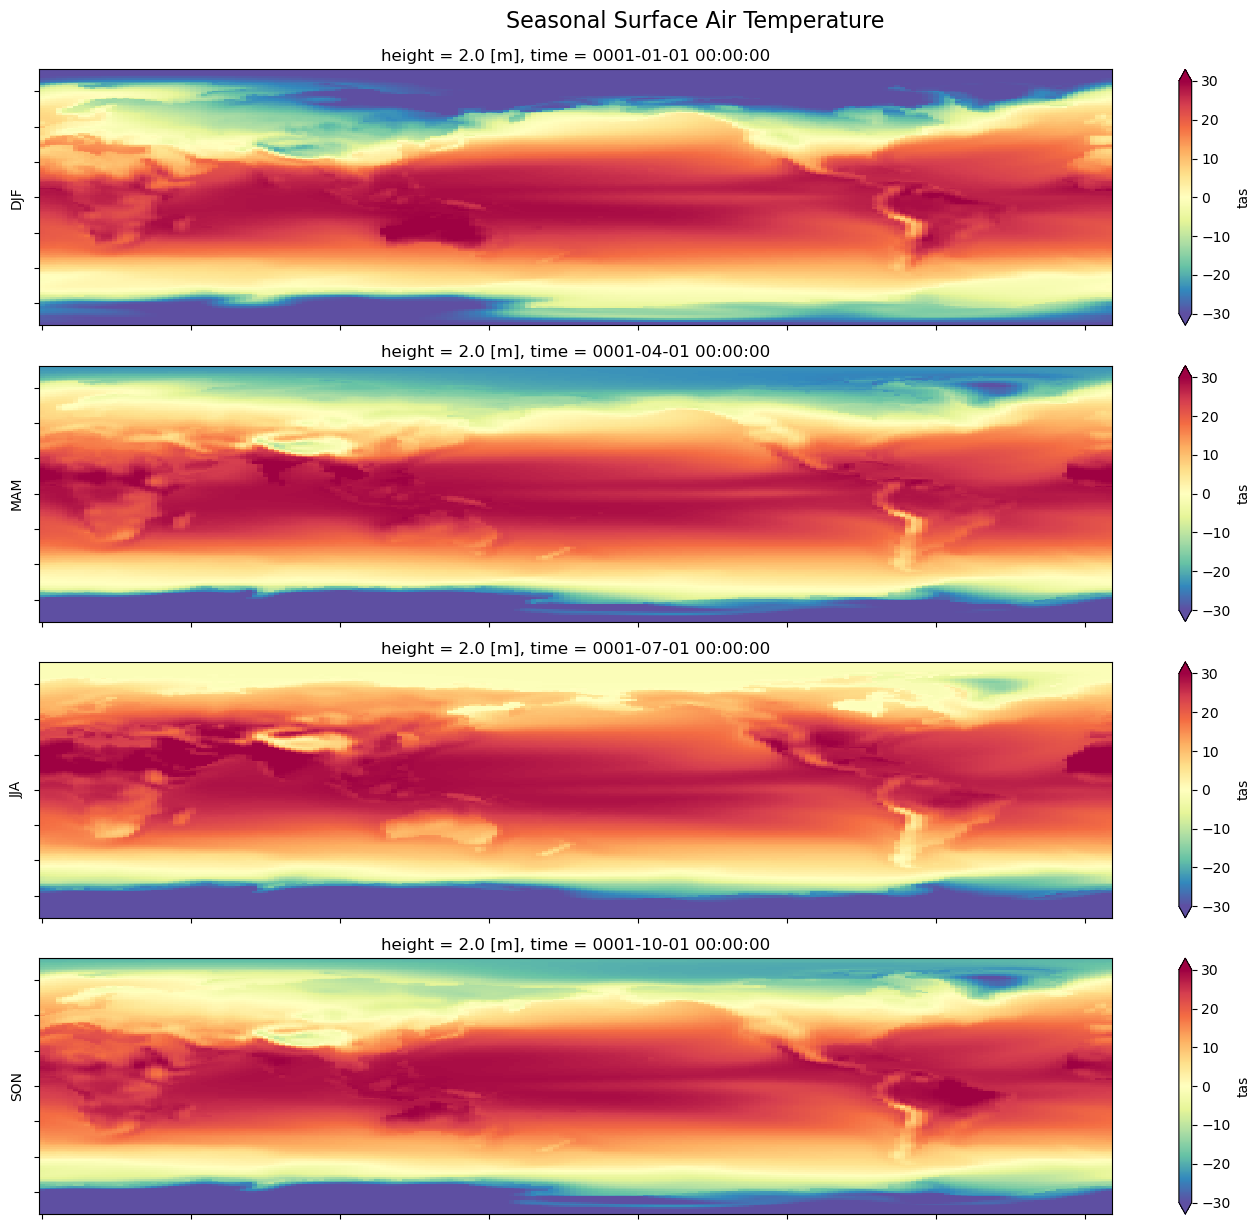

In [6]:
notnull = pd.notnull(season_climo["tas"][0])
tas_season = season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    tas_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

Notice that the time coordinates are `cftime` objects, with each season ("DJF", "MAM", "JJA", and "SON") represented by its middle month.

`cftime` objects are used because the time coordiantes are outside the Timestamp-valid range (approximately between years 1678 and 2262).

- More info here: https://xarray.pydata.org/en/v2022.03.0/user-guide/weather-climate.html#non-standard-calendars-and-dates-outside-the-timestamp-valid-range


In [7]:
season_climo.time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array([cftime.DatetimeProlepticGregorian(1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 10, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 8B 2.0
  * time     (time) object 32B 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### Custom Seasonal Climatology

**Groups time coordinates by season**

To calculate custom seasonal cycle climatology, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [8]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JunJulAug"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]

c_season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [9]:
c_season_climo.tas

<xarray.DataArray 'tas' (time: 4, lat: 145, lon: 192)> Size: 891kB
array([[[-38.74568939, -38.74568939, -38.74568939, ..., -38.74568939,
         -38.74568939, -38.74568939],
        [-36.58245468, -36.61849976, -36.65530777, ..., -36.47352982,
         -36.50952148, -36.54521942],
        [-35.74017334, -35.84892654, -35.95645142, ..., -35.40914154,
         -35.51865387, -35.62909698],
        ...,
        [-32.0694809 , -32.01528931, -31.96115875, ..., -32.24432373,
         -32.18037796, -32.1263504 ],
        [-32.59425354, -32.57166672, -32.55008316, ..., -32.66543961,
         -32.64432526, -32.61899185],
        [-33.51273727, -33.51273727, -33.51273727, ..., -33.51273727,
         -33.51273727, -33.51273727]],

       [[-56.2096405 , -56.2096405 , -56.2096405 , ..., -56.2096405 ,
         -56.2096405 , -56.2096405 ],
        [-52.31330872, -52.36031723, -52.40692902, ..., -52.16948318,
         -52.21759415, -52.26473999],
        [-51.48299408, -51.61407852, -51.74102783, ..., -51.06825256,
         -51.20875549, -51.34703445],
...
        [ -4.15014648,  -4.13455486,  -4.11836147, ...,  -4.20478487,
          -4.18330002,  -4.16762114],
        [ -4.25911999,  -4.25162458,  -4.24448299, ...,  -4.28251314,
          -4.2763319 ,  -4.26777029],
        [ -4.44926548,  -4.44926548,  -4.44926548, ...,  -4.44926548,
          -4.44926548,  -4.44926548]],

       [[-38.29449081, -38.29449081, -38.29449081, ..., -38.29449081,
         -38.29449081, -38.29449081],
        [-36.35746002, -36.39224243, -36.42734528, ..., -36.25349045,
         -36.28746796, -36.32162476],
        [-35.58590698, -35.68638992, -35.78586197, ..., -35.27788162,
         -35.38057709, -35.48319244],
        ...,
        [-24.59911537, -24.54461861, -24.49049377, ..., -24.7778244 ,
         -24.71206665, -24.65720177],
        [-25.07014275, -25.04795647, -25.027174  , ..., -25.13942909,
         -25.1194191 , -25.09457588],
        [-25.95426178, -25.95426178, -25.95426178, ..., -25.95426178,
         -25.95426178, -25.95426178]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 32B 0001-02-01 00:00:00 ... 0001-11-01 00:00:00
Attributes:
    operation:       temporal_avg
    mode:            climatology
    freq:            season
    weighted:        True
    custom_seasons:  ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNovDec']

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

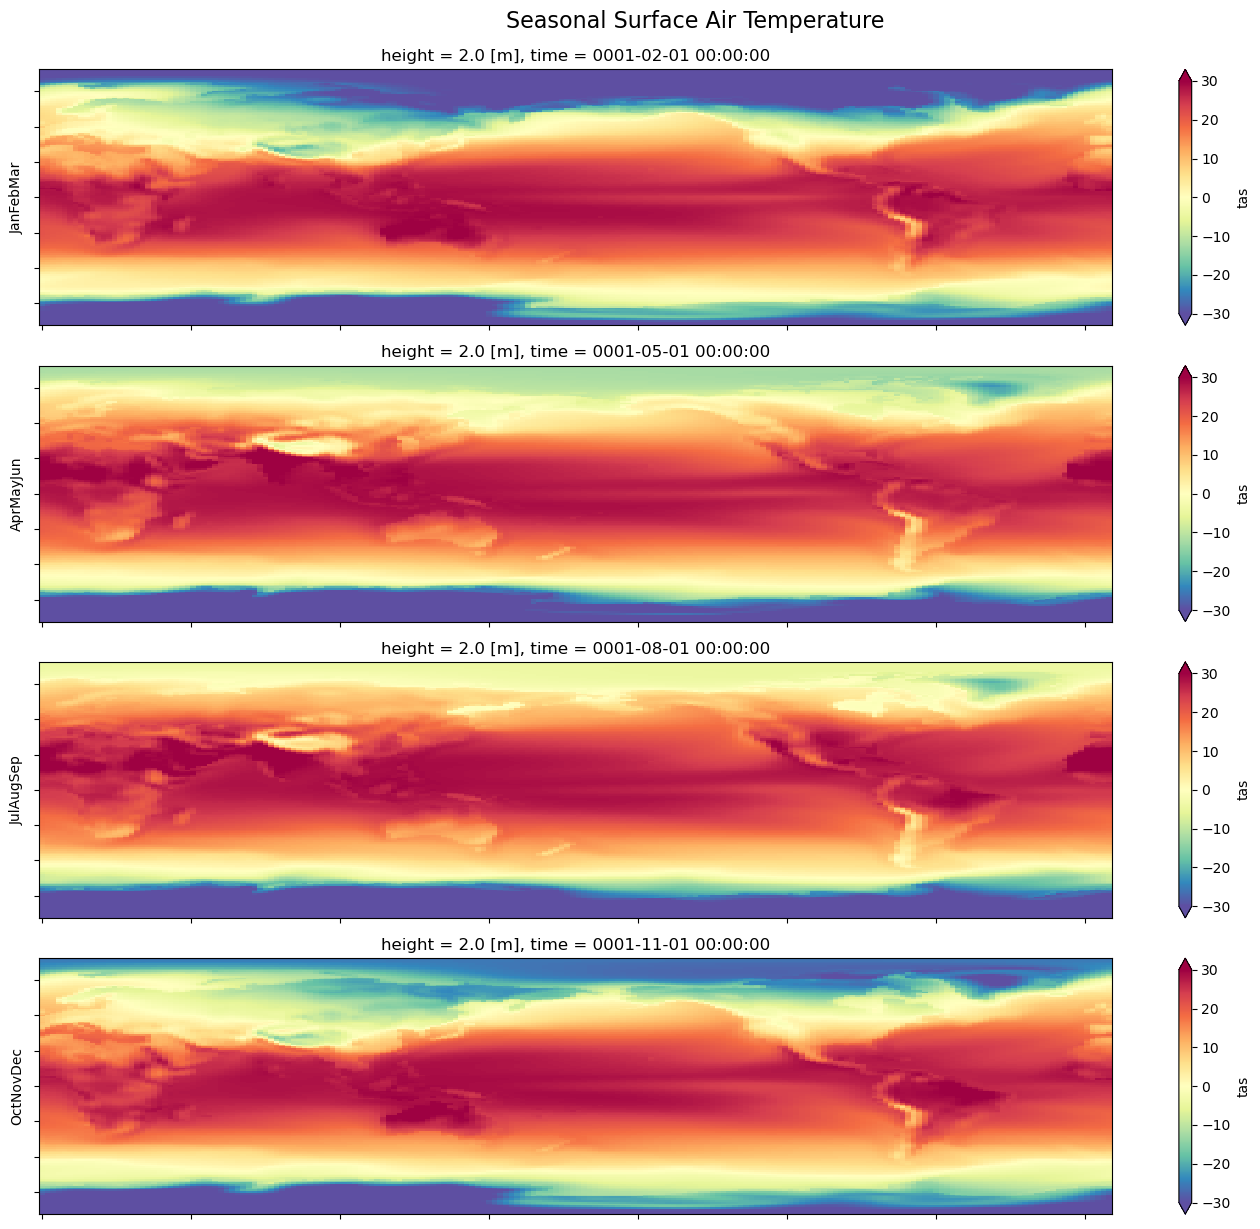

In [10]:
notnull = pd.notnull(c_season_climo["tas"][0])
tas_c_season = c_season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(tas_c_season.attrs["custom_seasons"]):
    tas_c_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

### Annual Climatology

**Groups time coordinates by month**


In [11]:
annual_climo = ds_monthly.temporal.climatology("tas", freq="month", weighted=True)

In [12]:
annual_climo.tas

<xarray.DataArray 'tas' (time: 12, lat: 145, lon: 192)> Size: 3MB
array([[[-28.21442795, -28.21442795, -28.21442795, ..., -28.21442795,
         -28.21442795, -28.21442795],
        [-27.14847946, -27.17834282, -27.20867348, ..., -27.06005478,
         -27.08879089, -27.11763954],
        [-26.4435463 , -26.53694916, -26.62967873, ..., -26.1612587 ,
         -26.25445938, -26.34812355],
        ...,
        [-31.93053436, -31.87295341, -31.81675529, ..., -32.11352158,
         -32.04728317, -31.99032974],
        [-32.46694946, -32.44190598, -32.41777802, ..., -32.543293  ,
         -32.52000809, -32.4929657 ],
        [-33.39895248, -33.39895248, -33.39895248, ..., -33.39895248,
         -33.39895248, -33.39895248]],

       [[-37.97247314, -37.97247314, -37.97247314, ..., -37.97247314,
         -37.97247314, -37.97247314],
        [-35.9917984 , -36.02771759, -36.06422424, ..., -35.88243866,
         -35.91858673, -35.9542923 ],
        [-35.13148499, -35.23939133, -35.34668732, ..., -34.80545044,
         -34.91286087, -35.02162933],
...
        [-24.97770691, -24.91987419, -24.86286926, ..., -25.1666317 ,
         -25.09855843, -25.03938293],
        [-25.40159607, -25.37743568, -25.3551445 , ..., -25.47573471,
         -25.45422173, -25.42788887],
        [-26.30274582, -26.30274582, -26.30274582, ..., -26.30274582,
         -26.30274582, -26.30274582]],

       [[-27.46326065, -27.46326065, -27.46326065, ..., -27.46326065,
         -27.46326065, -27.46326065],
        [-26.38991165, -26.42050743, -26.45174217, ..., -26.30039787,
         -26.32954788, -26.35881042],
        [-25.6327858 , -25.72666359, -25.82057571, ..., -25.35087395,
         -25.44388771, -25.53768921],
        ...,
        [-29.80114746, -29.74719429, -29.69542122, ..., -29.973629  ,
         -29.90939331, -29.85676384],
        [-30.31214523, -30.29234123, -30.27323341, ..., -30.3752346 ,
         -30.35642242, -30.3335495 ],
        [-31.22587013, -31.22587013, -31.22587013, ..., -31.22587013,
         -31.22587013, -31.22587013]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       month
    weighted:   True

### Daily Climatology

**Groups time coordinates by month and day.**

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [13]:
daily_climo = ds_hourly.temporal.climatology("tas", freq="day", weighted=True)

In [14]:
daily_climo.tas

<xarray.DataArray 'tas' (time: 365, lat: 145, lon: 192)> Size: 81MB
dask.array<truediv, shape=(365, 145, 192), dtype=float64, chunksize=(1, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B ...
  * time     (time) object 3kB 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       day
    weighted:   True

## 3. Calculate Departures (Anomalies)

Related API: [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)

In this example, we will be calculating the weighted departures of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- What are anomalies?
  - In climatology, “anomalies” refer to the difference between the value during a given time
    interval (e.g., the January average surface air temperature) and the long-term average value for
    that time interval (e.g., the average surface temperature over the last 30 Januaries).
- How is the climatology calculated?
  - In the departures API, the reference climatology is calculated internally so there is no need to pass one to this method.
  - You can still calculate the reference climatology using the climatology API.
  - If desired, use the `reference_period` argument to calculate anomalies relative to a
    climatological reference period (a subset of the entire time series). If no value is
    provided, the climatological reference period will be the full period covered by the
    dataset.
- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.


### Seasonal Anomalies

The `season_config` dictionary keyword argument can be passed to `.departures()` for more granular configuration. We will be sticking with the default settings.


In [15]:
season_departures = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [16]:
season_departures.tas

<xarray.DataArray 'tas' (time: 659, lat: 145, lon: 192)> Size: 147MB
array([[[-0.58952332, -0.58952332, -0.58952332, ..., -0.58952332,
         -0.58952332, -0.58952332],
        [-1.09177017, -1.10290527, -1.11154175, ..., -1.05168915,
         -1.06544495, -1.0780983 ],
        [-1.15142822, -1.188591  , -1.22366714, ..., -1.03422165,
         -1.07611465, -1.11405563],
        ...,
        [-1.49987602, -1.47577286, -1.44530678, ..., -1.55906868,
         -1.53568459, -1.51602364],
        [-1.70767593, -1.68932533, -1.66731644, ..., -1.76281166,
         -1.74707222, -1.72536469],
        [-1.46803665, -1.46803665, -1.46803665, ..., -1.46803665,
         -1.46803665, -1.46803665]],

       [[-1.97722244, -1.97722244, -1.97722244, ..., -1.97722244,
         -1.97722244, -1.97722244],
        [-1.78523636, -1.78010559, -1.7770462 , ..., -1.78342056,
         -1.78052139, -1.78041077],
        [-1.86477661, -1.86896515, -1.87456131, ..., -1.84337997,
         -1.84798431, -1.85388184],
...
        [ 0.50043428,  0.50759256,  0.5102756 , ...,  0.50164866,
          0.50169188,  0.50637573],
        [ 0.50042224,  0.50507736,  0.50940531, ...,  0.48725533,
          0.4880656 ,  0.49204886],
        [ 0.54013848,  0.54013848,  0.54013848, ...,  0.54013848,
          0.54013848,  0.54013848]],

       [[ 0.21573257,  0.21573257,  0.21573257, ...,  0.21573257,
          0.21573257,  0.21573257],
        [ 0.00947952, -0.00642776, -0.0196228 , ...,  0.05247498,
          0.037117  ,  0.02135849],
        [ 0.04763412,  0.01293564, -0.02537918, ...,  0.16802216,
          0.13085556,  0.08817673],
        ...,
        [ 5.87438297,  5.94229126,  6.00926971, ...,  5.6408205 ,
          5.7134676 ,  5.79356194],
        [ 5.48866081,  5.5266571 ,  5.56793213, ...,  5.37800312,
          5.40638351,  5.44045258],
        [ 5.05544662,  5.05544662,  5.05544662, ...,  5.05544662,
          5.05544662,  5.05544662]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 5kB 1850-04-01 00:00:00 ... 2014-10-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 departures
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

### Custom Seasonal Anomalies

To calculate custom seasonal cycle anomalies, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [17]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JulAugSep"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]
c_season_departs = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [18]:
c_season_departs.tas

<xarray.DataArray 'tas' (time: 660, lat: 145, lon: 192)> Size: 147MB
array([[[ 0.30404663,  0.30404663,  0.30404663, ...,  0.30404663,
          0.30404663,  0.30404663],
        [ 0.36520004,  0.35329437,  0.33778   , ...,  0.40762329,
          0.3941803 ,  0.38028717],
        [ 0.5711937 ,  0.54114532,  0.51060486, ...,  0.6612854 ,
          0.63129425,  0.6011467 ],
        ...,
        [-4.49204254, -4.49573517, -4.49764633, ..., -4.45085144,
         -4.46473312, -4.47567368],
        [-4.54133224, -4.54836273, -4.55043411, ..., -4.50736237,
         -4.5208168 , -4.53223419],
        [-4.10101318, -4.10101318, -4.10101318, ..., -4.10101318,
         -4.10101318, -4.10101318]],

       [[-2.3446846 , -2.3446846 , -2.3446846 , ..., -2.3446846 ,
         -2.3446846 , -2.3446846 ],
        [-2.72401428, -2.72953033, -2.73215485, ..., -2.69366455,
         -2.70578384, -2.71579742],
        [-2.8057785 , -2.83257294, -2.85590363, ..., -2.70781326,
         -2.74424744, -2.77590179],
...
        [ 1.75831985,  1.75575376,  1.75691819, ...,  1.77385426,
          1.76290703,  1.75874662],
        [ 1.87204409,  1.87170196,  1.87422705, ...,  1.87372851,
          1.87358499,  1.87194395],
        [ 2.00157356,  2.00157356,  2.00157356, ...,  2.00157356,
          2.00157356,  2.00157356]],

       [[-0.28557205, -0.28557205, -0.28557205, ..., -0.28557205,
         -0.28557205, -0.28557205],
        [-0.26680374, -0.27238464, -0.27745056, ..., -0.25345993,
         -0.25799179, -0.26165771],
        [-0.24026489, -0.25225067, -0.26608276, ..., -0.19800949,
         -0.21153641, -0.22675705],
        ...,
        [ 6.18972588,  6.28137779,  6.36515808, ...,  5.88415146,
          5.9856987 ,  6.09294701],
        [ 5.75325775,  5.79308891,  5.85096931, ...,  5.61413383,
          5.64881134,  5.69875908],
        [ 5.32911682,  5.32911682,  5.32911682, ...,  5.32911682,
          5.32911682,  5.32911682]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 5kB 1850-02-01 00:00:00 ... 2014-11-01 00:00:00
Attributes:
    operation:       temporal_avg
    mode:            departures
    freq:            season
    weighted:        True
    custom_seasons:  ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNovDec']

### Annual Anomalies


In [19]:
annual_departures = ds_monthly.temporal.departures("tas", freq="month", weighted=True)

In [20]:
annual_departures.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)> Size: 441MB
array([[[ 1.02746201,  1.02746201,  1.02746201, ...,  1.02746201,
          1.02746201,  1.02746201],
        [ 1.19550705,  1.18815422,  1.16651344, ...,  1.25013351,
          1.23219299,  1.2116642 ],
        [ 1.46669388,  1.44287872,  1.42212868, ...,  1.53920364,
          1.51576614,  1.49129677],
        ...,
        [-3.27492523, -3.30706978, -3.3486805 , ..., -3.19853592,
         -3.22591019, -3.24889755],
        [-3.33357239, -3.35164261, -3.37155914, ..., -3.27233505,
         -3.29122543, -3.31744385],
        [-3.00098038, -3.00098038, -3.00098038, ..., -3.00098038,
         -3.00098038, -3.00098038]],

       [[-0.84364319, -0.84364319, -0.84364319, ..., -0.84364319,
         -0.84364319, -0.84364319],
        [-0.5828476 , -0.59806061, -0.61303711, ..., -0.53842926,
         -0.55280304, -0.56754303],
        [-0.48284912, -0.49863052, -0.51592255, ..., -0.43305969,
         -0.45086288, -0.46794891],
...
        [12.00904846, 12.1377697 , 12.2563324 , ..., 11.55307579,
         11.70439339, 11.86277771],
        [11.19392395, 11.2524662 , 11.31940842, ..., 11.00472641,
         11.06731987, 11.12167549],
        [ 9.3935051 ,  9.3935051 ,  9.3935051 , ...,  9.3935051 ,
          9.3935051 ,  9.3935051 ]],

       [[-1.52723312, -1.52723312, -1.52723312, ..., -1.52723312,
         -1.52723312, -1.52723312],
        [-1.80300522, -1.80407143, -1.80956459, ..., -1.79553413,
         -1.79644394, -1.79920959],
        [-1.97462082, -1.97897911, -1.98453903, ..., -1.96074104,
         -1.96693993, -1.97067261],
        ...,
        [ 5.5448761 ,  5.60659981,  5.6578846 , ...,  5.35509872,
          5.42089844,  5.49032402],
        [ 5.68313217,  5.67895317,  5.72336769, ...,  5.62318993,
          5.63481903,  5.66713715],
        [ 5.93663979,  5.93663979,  5.93663979, ...,  5.93663979,
          5.93663979,  5.93663979]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

### Daily Anomalies

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [21]:
daily_departures = ds_hourly.temporal.departures("tas", freq="day", weighted=True)

In [22]:
daily_departures.tas

<xarray.DataArray 'tas' (time: 1826, lat: 145, lon: 192)> Size: 407MB
dask.array<sub, shape=(1826, 145, 192), dtype=float64, chunksize=(1, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B ...
  * time     (time) object 15kB 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       day
    weighted:   True